In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_xang.csv"

In [3]:
var_file_name = 'var_gia_cafe_xang.joblib'
varma_file_name = 'var_gia_cafe_xang.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

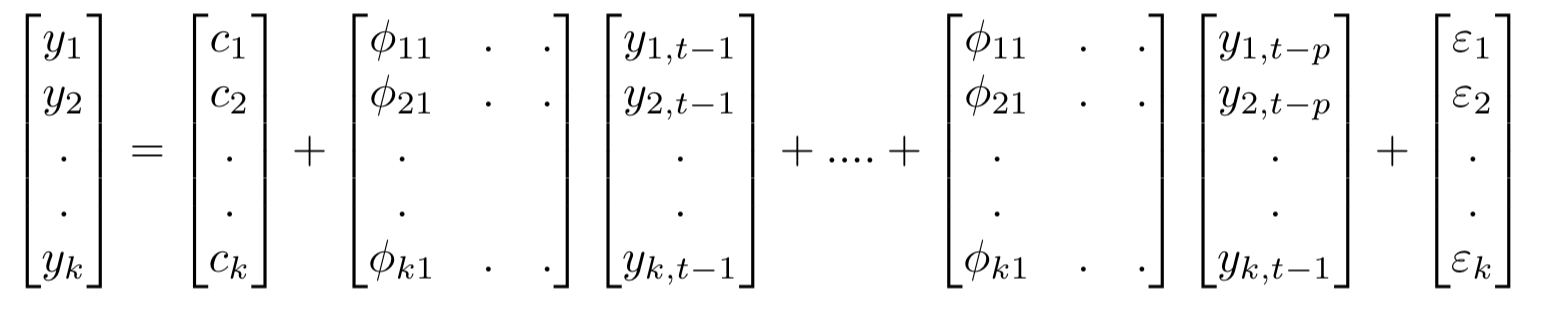

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,RON 95-III
date,,
2018-08-22,33700.0,21.17
2018-08-23,33400.0,21.17
2018-08-24,33100.0,21.17
2018-08-25,33300.0,21.17
2018-08-26,33300.0,21.17


<Axes: >

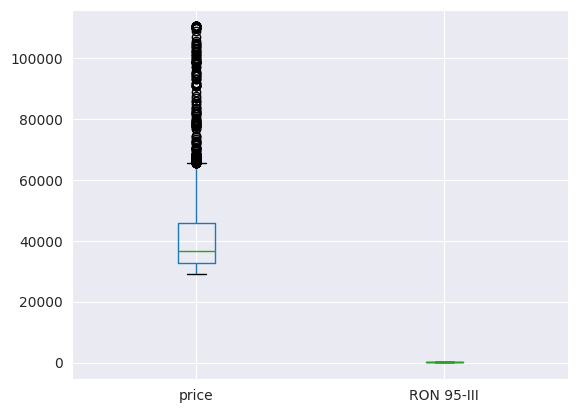

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 247


<Axes: >

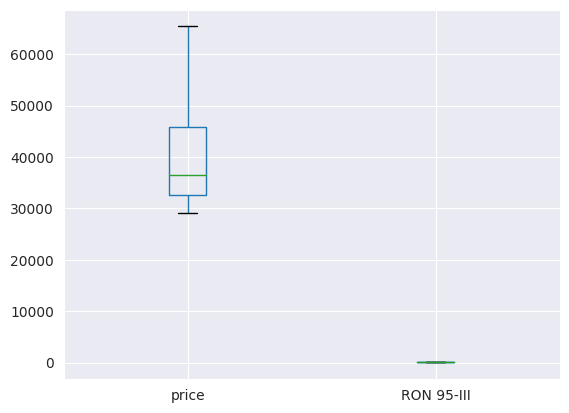

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.547534
RON 95-III,0.547534,1.000000


In [12]:
fillter_feature = ['price', 'RON 95-III']
df = df[fillter_feature]

In [13]:
from google.colab import files
df.to_csv('./gia_cafe_xang.csv')
files.download('./gia_cafe_xang.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.547534
RON 95-III,0.547534,1.000000


<Axes: xlabel='date'>

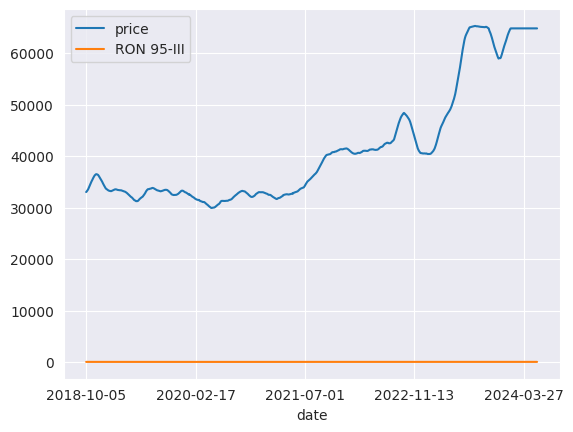

In [ ]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [ ]:
nobs = int(len(df) * 0.7)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1442, 2)
(619, 2)


In [ ]:
from google.colab import files


## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.32
 No. Lags Chosen       = 4
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9782. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5135
 No. Lags Chosen       = 17
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.5268. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9647
 No. Lags Chosen       = 3
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0016. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1336
 No. Lags Chosen       = 16
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0009. Rejecting Null Hypothesis.
 => Series is Stationary.




## Train model

In [ ]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -5.178455328265728
BIC :  -5.15648700163002
FPE :  0.005636706622491233
HQIC:  -5.1702546104338 

Lag Order = 2
AIC :  -5.237046102865938
BIC :  -5.200411608724957
FPE :  0.005315936693187542
HQIC:  -5.223370069347277 

Lag Order = 3
AIC :  -5.240909448060296
BIC :  -5.189592257840593
FPE :  0.005295439533267502
HQIC:  -5.22175154804439 

Lag Order = 4
AIC :  -5.238577088115679
BIC :  -5.1725606427785715
FPE :  0.005307805741201188
HQIC:  -5.2139307583805365 

Lag Order = 5
AIC :  -5.233981232420224
BIC :  -5.153248942384445
FPE :  0.0053322572409695655
HQIC:  -5.203839897300335 

Lag Order = 6
AIC :  -5.231904645511875
BIC :  -5.136439890575962
FPE :  0.005343343736193372
HQIC:  -5.19626171686606 

Lag Order = 7
AIC :  -5.229138766942883
BIC :  -5.118924896207327
FPE :  0.005358146098867254
HQIC:  -5.187987644122043 

Lag Order = 8
AIC :  -5.2246835724732925
BIC :  -5.0997039042624355
FPE :  0.005382074705389439
HQIC:  -5.178017642288056 

Lag Order = 9
AIC :  -5.

In [ ]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,0.6390,0.6465,1.895,0.6418
1,-5.168,-5.146,0.005694,-5.160
2,-5.230,-5.193*,0.005351,-5.216
3,-5.237,-5.184,0.005319,-5.217
4,-5.236,-5.168,0.005322,-5.211
5,-5.232,-5.149,0.005341,-5.201
6,-5.232,-5.134,0.005344,-5.195
7,-5.230,-5.117,0.005355,-5.187
8,-5.227,-5.099,0.005369,-5.179
9,-5.224,-5.081,0.005387,-5.170


In [ ]:
model_var = model.fit(47)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     07:18:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.03590
Nobs:                     1394.00    HQIC:                  -5.48306
Log likelihood:           241.818    FPE:                 0.00318382
AIC:                     -5.75010    Det(Omega_mle):      0.00279051
--------------------------------------------------------------------
Results for equation price
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.351284         0.307436            1.143           0.253
L1.price               0.690923         0.027339           25.273           0.000
L1.RON 95-III         28.508707        62.245992        

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.01
RON 95-III : 2.0


In [ ]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

47


array([[ 4.88888889e+01, -5.24444444e-02],
       [ 3.11111111e+01, -6.28888889e-02],
       [ 3.77777778e+01, -6.28888889e-02],
       [ 3.77777778e+01, -6.28888889e-02],
       [ 3.77777778e+01, -6.28888889e-02],
       [ 3.55555556e+01, -6.28888889e-02],
       [ 3.33333333e+01, -6.28888889e-02],
       [ 2.66666667e+01, -6.28888889e-02],
       [ 3.77777778e+01, -6.28888889e-02],
       [ 6.00000000e+01, -6.28888889e-02],
       [ 7.11111111e+01, -6.28888889e-02],
       [ 7.11111111e+01, -8.37777778e-02],
       [ 7.33333333e+01, -8.37777778e-02],
       [ 1.44444444e+02, -8.37777778e-02],
       [ 1.31111111e+02, -8.37777778e-02],
       [ 1.37777778e+02, -8.37777778e-02],
       [ 1.48888889e+02, -8.37777778e-02],
       [ 1.35555556e+02, -8.37777778e-02],
       [ 1.33333333e+02, -8.37777778e-02],
       [ 1.35555556e+02, -8.37777778e-02],
       [ 1.48888889e+02, -8.37777778e-02],
       [ 1.51111111e+02, -8.37777778e-02],
       [ 1.60000000e+02, -8.37777778e-02],
       [ 1.

In [ ]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [ ]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,RON 95-III_2d
date,,
2022-09-16,70.185158,-0.051812
2022-09-17,70.317840,-0.051193
2022-09-18,63.832129,-0.049089
2022-09-19,64.416695,-0.039496
2022-09-20,63.857668,-0.038022
...,...,...
2024-05-25,9.752083,0.002491
2024-05-26,9.717970,0.002480
2024-05-27,9.683473,0.002490


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2022-09-16,47827.962936
2022-09-17,47898.280775
2022-09-18,47962.112904
2022-09-19,48026.529600
2022-09-20,48090.387267
...,...
2024-05-25,55441.207273
2024-05-26,55450.925242
2024-05-27,55460.608715


### Đánh giá mô hình VAR

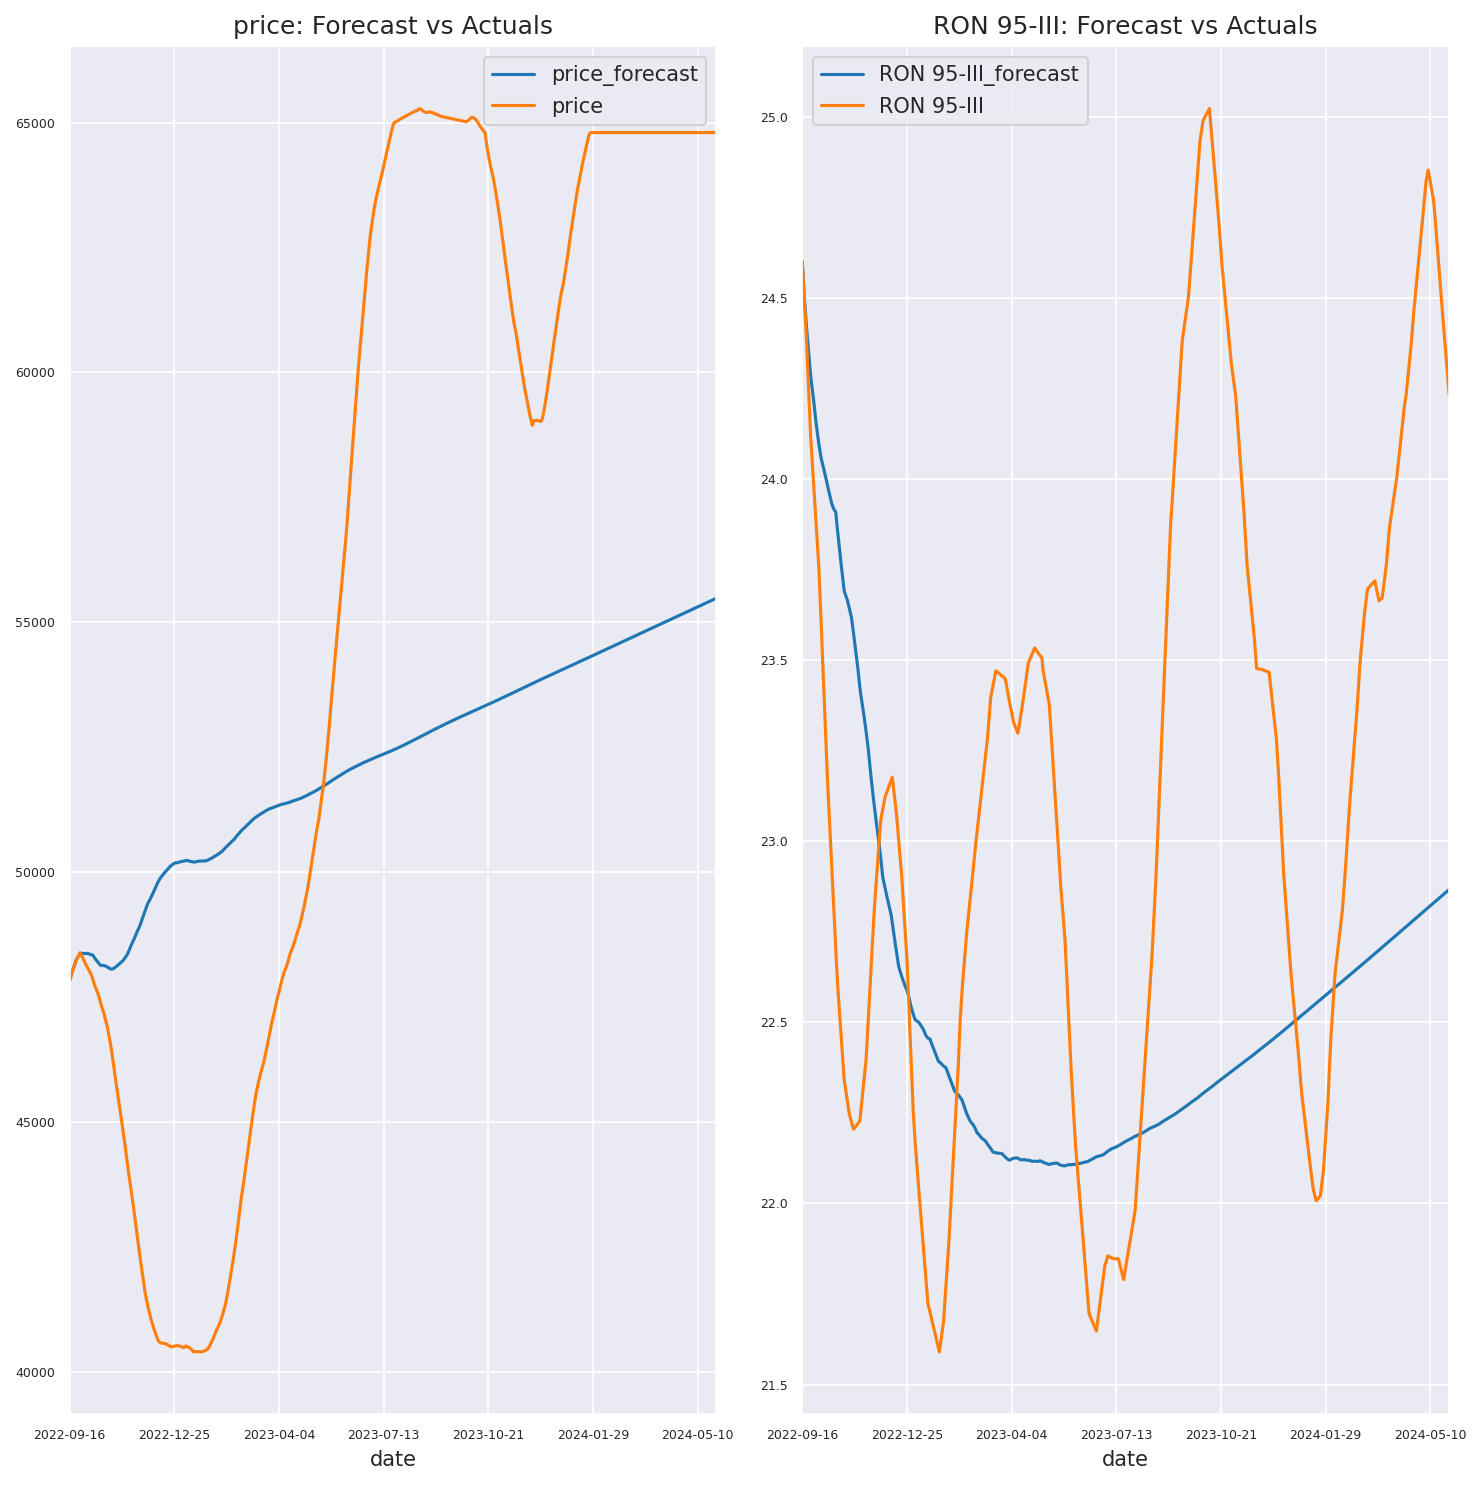

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [ ]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  13.9303
rmse   :  8632.9393


In [ ]:
import joblib
joblib.dump(model_var, var_file_name)
from google.colab import files
files.download(var_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
columns_train = fillter_feature

In [ ]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11359.813, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11484.606, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11379.330, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11359.566, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11482.610, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11359.779, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11361.778, Time=2.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11357.577, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11357.825, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11357.790, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11377.338, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11359.789, Time=0.62 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.700 seconds
optimal order for:price is: (0, 1, 1)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (0, 1, 1)
{'p': 0, 'q': 1, 'RMSE Open': 341.9862784041527}


In [ ]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(3,1),trends = 'n').fit( disp=False)


In [ ]:
result = model_varma.forecast(len(df_test))

In [ ]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  13.529
rmse   :  7940.1725


In [ ]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619 entries, 2022-09-16 to 2024-05-26
Freq: D
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                619 non-null    float64
 1   RON 95-III           619 non-null    float64
 2   price_forecast       619 non-null    float64
 3   RON 95-III_forecast  619 non-null    float64
dtypes: float64(4)
memory usage: 24.2 KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619 entries, 2022-09-16 to 2024-05-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       619 non-null    float64
 1   RON 95-III  619 non-null    float64
dtypes: float64(2)
memory usage: 14.5+ KB


In [ ]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619 entries, 2022-09-16 to 2024-05-26
Freq: D
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                619 non-null    float64
 1   RON 95-III           619 non-null    float64
 2   price_forecast       619 non-null    float64
 3   RON 95-III_forecast  619 non-null    float64
dtypes: float64(4)
memory usage: 24.2 KB


In [ ]:
df_test.index = pd.to_datetime(df_test.index)
df_train.index = pd.to_datetime(df_train.index)


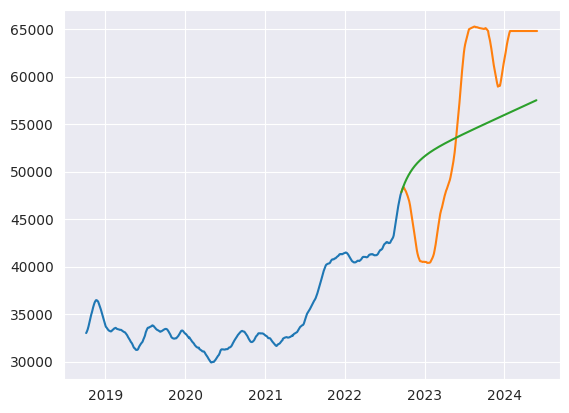

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_train.price)
plt.plot(df_test.price)
plt.plot(inv_res.price_forecast)

plt.show()

In [ ]:
var_file_name = 'var_gia_cafe_xang.joblib'
varma_file_name = 'varma_gia_cafe_xang.joblib'

In [ ]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_cafe_xang.joblib']